In [70]:

import matplotlib.pyplot as plt

def draw(list,mode,dt):
    """時間変化する値を描画する関数
    引数:
        list:リスト
            [[X_list,name],[Y_list,name],[Z_list,name]...]
            X_list:状態値のリスト
        mode:表示したい状態値
                0:回頭角phi
                1:回頭角速度r
                2:時定数T
                3:追従性指数K
        dt:観測幅

    """
    if mode==0:
        for l in list:
            plt.plot([t*dt for t in range(len(l[0]))],[l[0][i][0] for i in range(len(l[0]))],label=f'{l[1]}')
        plt.xlabel("time[s]")
        plt.ylabel("angle phi[rad]")
        plt.title("time VS angle")
        plt.legend()
        

    elif mode==1:
        for l in list:
            plt.plot([t*dt for t in range(len(l[0]))],[l[0][i][1] for i in range(len(l[0]))],label=f'{l[1]}')
        plt.xlabel("time[s]")
        plt.ylabel("angle rate r[rad/s]")
        plt.title("time VS angle rate")
        plt.legend()
        
    
    elif mode==2:
        for l in list:
            plt.plot([t*dt for t in range(len(l[0]))],[1/l[0][i][2] for i in range(len(l[0]))],label=f'{l[1]}')
        plt.xlabel("time[s]")
        plt.ylabel("T [s]")
        plt.title("time VS T")
        #plt.xlim(-5,200)
        #plt.ylim(-0.1,1)
        plt.legend()
        
    
    elif mode==3:
        for l in list:
            plt.plot([t*dt for t in range(len(l[0]))],[l[0][i][3]/l[0][i][2] for i in range(len(l[0]))],label=f'{l[1]}')
        plt.xlabel("time[s]")
        plt.ylabel("K [1/s]")
        plt.title("time VS K")
        #plt.ylim(-0.1,0.3)
        #plt.xlim(-5,200)
        plt.legend()
        
    
    else:
        print("mode must be 0,1,2,3")






In [71]:
# -*- coding: utf-8 -*-

#モジュールのインポート
import numpy as np

def KTsim2(dt,simulate_time,X0,Q,R,delta):

    """KTモデルのシミュレーションの値を生成する
    引数:
        dt:観測幅[s],float
        simulate_time:シミュレーション時間[s],int
        x0:状態値[phi,r],ndarray
            phi:回頭角[rad]
            r:回答角速度[rad/s]
            theta1=1/T
            theta2=K/T
            K:追従性指数[1/s]
            T:時定数[s]
        Q:システムノイズの分散共分散行列,ndarray 4行4列
        R:観測ノイズの分散共分散行列,ndarray 2行2列
        delta:舵角[rad],list

    返り値
        X_list:状態値のリスト[[phi0,r0],[phi1,r1],[phi2,r2]・・・]
            phi:回頭角[rad]
            r:回答角速度[rad/s]
            theta1:1/T[1/s]
            theta2:K/T[1/s^2]

        Y_list:観測値のリスト[[phi0,r0],[phi1,r1],[phi2,r2]・・・]
    """


    X_list=[]
    X_list.append(X0)
    Y_list=[]
    Y0=np.array([X0[0],X0[1]])
    Y_list.append(Y0)

    #観測行列Hを生成
    H=np.array([
        [1,0,0,0],
        [0,1,0,0]
        ])

    for i in range(int(simulate_time/dt)):
        
        #システムノイズ
        v=np.array(np.diag(np.random.normal(loc=0,scale=Q))).reshape(-1,1)
        #観測ノイズ
        w=np.array(np.diag(np.random.normal(loc=0,scale=R))).reshape(-1,1)

        #状態値を更新
        X=X_list[i]

        #状態値を計算
        X=np.array([
            X[0]+X[1]*dt,
            (1-X[2]*dt)*X[1]+X[3]*dt*delta[i],
            X[2],
            X[3]
        ])+v

        X_list.append(X)

        #観測値を計算
        Y=H@X+w

        Y_list.append(Y)
    

    return X_list,Y_list

In [72]:
# -*- coding: utf-8 -*-

#モジュールのインポート
import numpy as np

def ekf(dt,simulate_time,X_hat,Y,Q,R,V_hat,delta):

    """KTモデルのekf(拡張カルマンフィルタ)
    引数:
        dt:観測幅[s],float
        simulate_time:シミュレーション時間[s],int
        X_hat:状態推定値の初期値　4行1列
            phi:回頭角[rad]
            r:回答角速度[rad/s]
            theta1:パラメーターθ1
            theta2:パラメーターθ2

        Y:観測値[phi,r],list 2行1列
            phi:回頭角[rad]
            r:回答角速度[rad/s]
        Q:システムノイズの分散共分散行列,ndarray 4行4列
        R:観測ノイズの分散共分散行列,ndarray 2行2列
        P:共分散行列の初期値 4行4列
        delta:舵角[rad],list

    返り値
        X_hat_list:状態推定値のリスト[[phi0,r0,theta10,theta20],[phi1,r1,theta11,theta21]・・・]
            phi:回頭角[rad]
            r:回答角速度[rad/s]
            theta1
            theta2
    """

    #観測関数行列H　2行4列
    H=np.array(
        [[1,0,0,0],
        [0,1,0,0]], dtype=np.float32
    )


    X_hat_list=[] #状態推定値のリスト
    X_hat_list.append(X_hat) #初期値を設定
    V_hat_list=[] #分散共分散行列のリスト
    V_hat_list.append(V_hat) #初期値を設定
    A_list=[]


    #逐次的に状態を推定
    for i in range(int(simulate_time/dt)):
        
        #状態量を更新する
        X=X_hat_list[i]

        #FのヤコビアンA 4行4列
        A=np.array([
            [1,dt,0,0],
            [0,(1-X[2])*dt,-X[1]*dt,delta[i]*dt],
            [0,0,1,0],
            [0,0,0,1]
            ], dtype=np.float32)

        A_list.append(A)

        #予測ステップ
        ##事前推定値
        _X_hat=np.array([
            X[0]+X[1]*dt,
            (1-X[2]*dt)*X[1]+X[3]*dt*delta[i],
            X[2],
            X[3]
            ], dtype=np.float32)

        ##事前誤差共分散
        _V_hat=A@np.array([
            [V_hat_list[i][0][0],0,0,0],
            [0,V_hat_list[i][1][1],0,0],
            [0,0,V_hat_list[i][2][2],0],
            [0,0,0,V_hat_list[i][3][3]]
            ], dtype=np.float32)@A.T+Q

        #更新ステップ
        ##逆行列の計算
        inv_VR=np.linalg.pinv(H@_V_hat@H.T+R)

        ##カルマンゲイン
        G=_V_hat@H.T@inv_VR

        ##事後推定値
        X_hat=_X_hat+G@(Y[i]-H@_X_hat)
        X_hat_list.append(X_hat)

        ##事後誤差共分散
        V_hat=_V_hat-G@H@_V_hat
        V_hat_list.append(V_hat)

    return X_hat_list,V_hat_list,A_list

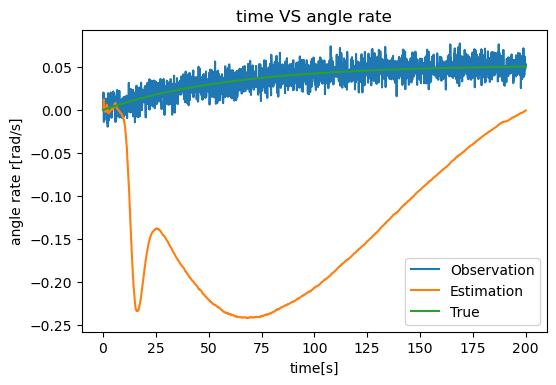

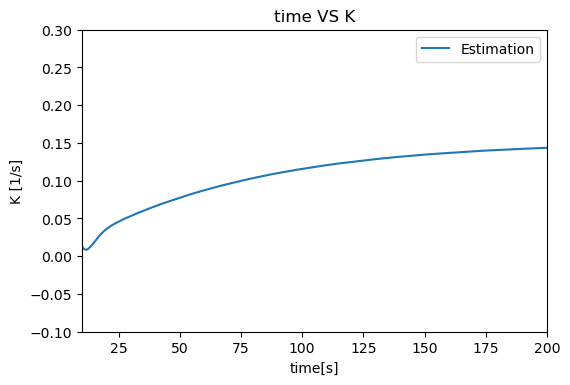

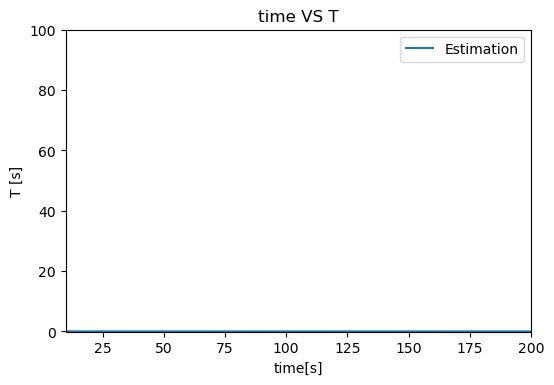

In [73]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from KTsimulatator2 import KTsim2
from draw import draw
from ekf import ekf


if __name__=="__main__":

    #シミュレーションのパラメーターを設定
    dt=0.1
    simulate_time=200
    K=0.15
    T=60
    X0=np.array([[0],[0],[1/T],[K/T]],dtype=np.float32)

    Q_true=np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]]
    ,dtype=np.float32)

    R_true=np.array([
        [0,0],
        [0,0.01]]
        ,dtype=np.float32)

    delta=[20*np.pi/180 for i in range(int(simulate_time/dt))]


    X_list,Y_list =KTsim2(dt,simulate_time,X0,Q_true,R_true,delta)


    #拡張カルマンフィルタ用のパラメーターを設定
    dt=0.1
    X_hat0=np.array([[0],[0],[0.09],[0.001]],dtype=np.float32)


    Q=np.array([
    [0,0,0,0],
    [0,0.001,0,0],
    [0,0,0.001,0],
    [0,0,0,0.0001]]
    ,dtype=np.float32)

    R=np.array([
        [0,0],
        [0,0.1]]
        ,dtype=np.float32)

    V_hat=np.array([
        [100000,0,0,0],
        [0,10000,0,0],
        [0,0,10000,0],
        [0,0,0,10000]]
        ,dtype=np.float32)

    #カルマンフィルタを実行
    X_hat_list,V_hat_list,A_list=ekf(dt,simulate_time,X_hat0,Y_list,Q,R,V_hat,delta)

    fig = plt.figure(dpi=100)
    draw([[Y_list,"Observation"],[X_hat_list,"Estimation"],[X_list,"True"]],1,dt)
    plt.show()
    fig = plt.figure(dpi=100)
    draw([[X_hat_list,"Estimation"]],3,dt)
    plt.show()
    fig = plt.figure(dpi=100)
    draw([[X_hat_list,"Estimation"]],2,dt)
    plt.show()